# Detection and dealing with bias in EHR data

Biases in EHR data, originating from sources like selective documentation and demographic disparities, challenge healthcare analytics by skewing research outcomes and clinical decisions. These biases can lead to misrepresentation of patient groups, underrepresentation of minorities, and inaccuracies in disease prevalence.
Exploratory data analysis (EDA), through data visualization, statistical summaries, and pattern identification, is a critical step in uncovering and mitigating biases.

In this tutorial, we outline the various sources of bias and show how they can be detected and potentially mitigated.
Note that many biases are already inherent to the data collection process itself and can only be unveiled but not always dealt with.
We make use of the [Diabetes 130-US Hospitals for years 1999-2008](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) dataset ("Diabetes-130") and synthetic datasets. ([Strack et al. 2014](https://www.hindawi.com/journals/bmri/2014/781670/))

## Environment setup

In [2]:
# Install fairlearn if you do not already have it.
# !pip install fairlearn

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import ehrapy as ep
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tableone import TableOne
from anndata import AnnData

import warnings

warnings.filterwarnings("ignore")
from utils import hist_plot_num_medication

In [3]:
plt.rcParams["figure.figsize"] = [10, 5]

## The "Diabetes 130-US Hospitals for years 1998-2008" ("Diabetes-130") dataset

The dataset encompasses ten years of clinical data from 130 US hospitals, detailing hospital records for diabetic patients, including laboratory tests, medications, and up to 14-day stays.
This dataset is per-patient-visit, not a per-patient basis. Beware that the same patient may be included multiple times.

### Features

|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |

### Loading Diabetes-130

We load a [preprocessed version derived by the fairlearn team](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html).

In [5]:
adata = ep.dt.diabetes_130_fairlearn()
ep.ad.move_to_obs(adata, ["race", "gender", "age"], copy_obs=True)

AnnData object with n_obs × n_vars = 101766 × 24
    obs: 'race', 'gender', 'age'
    var: 'ehrapy_column_type'
    layers: 'original'

A quick check on the presence of missing data in the dataset can be obtained

<Axes: >

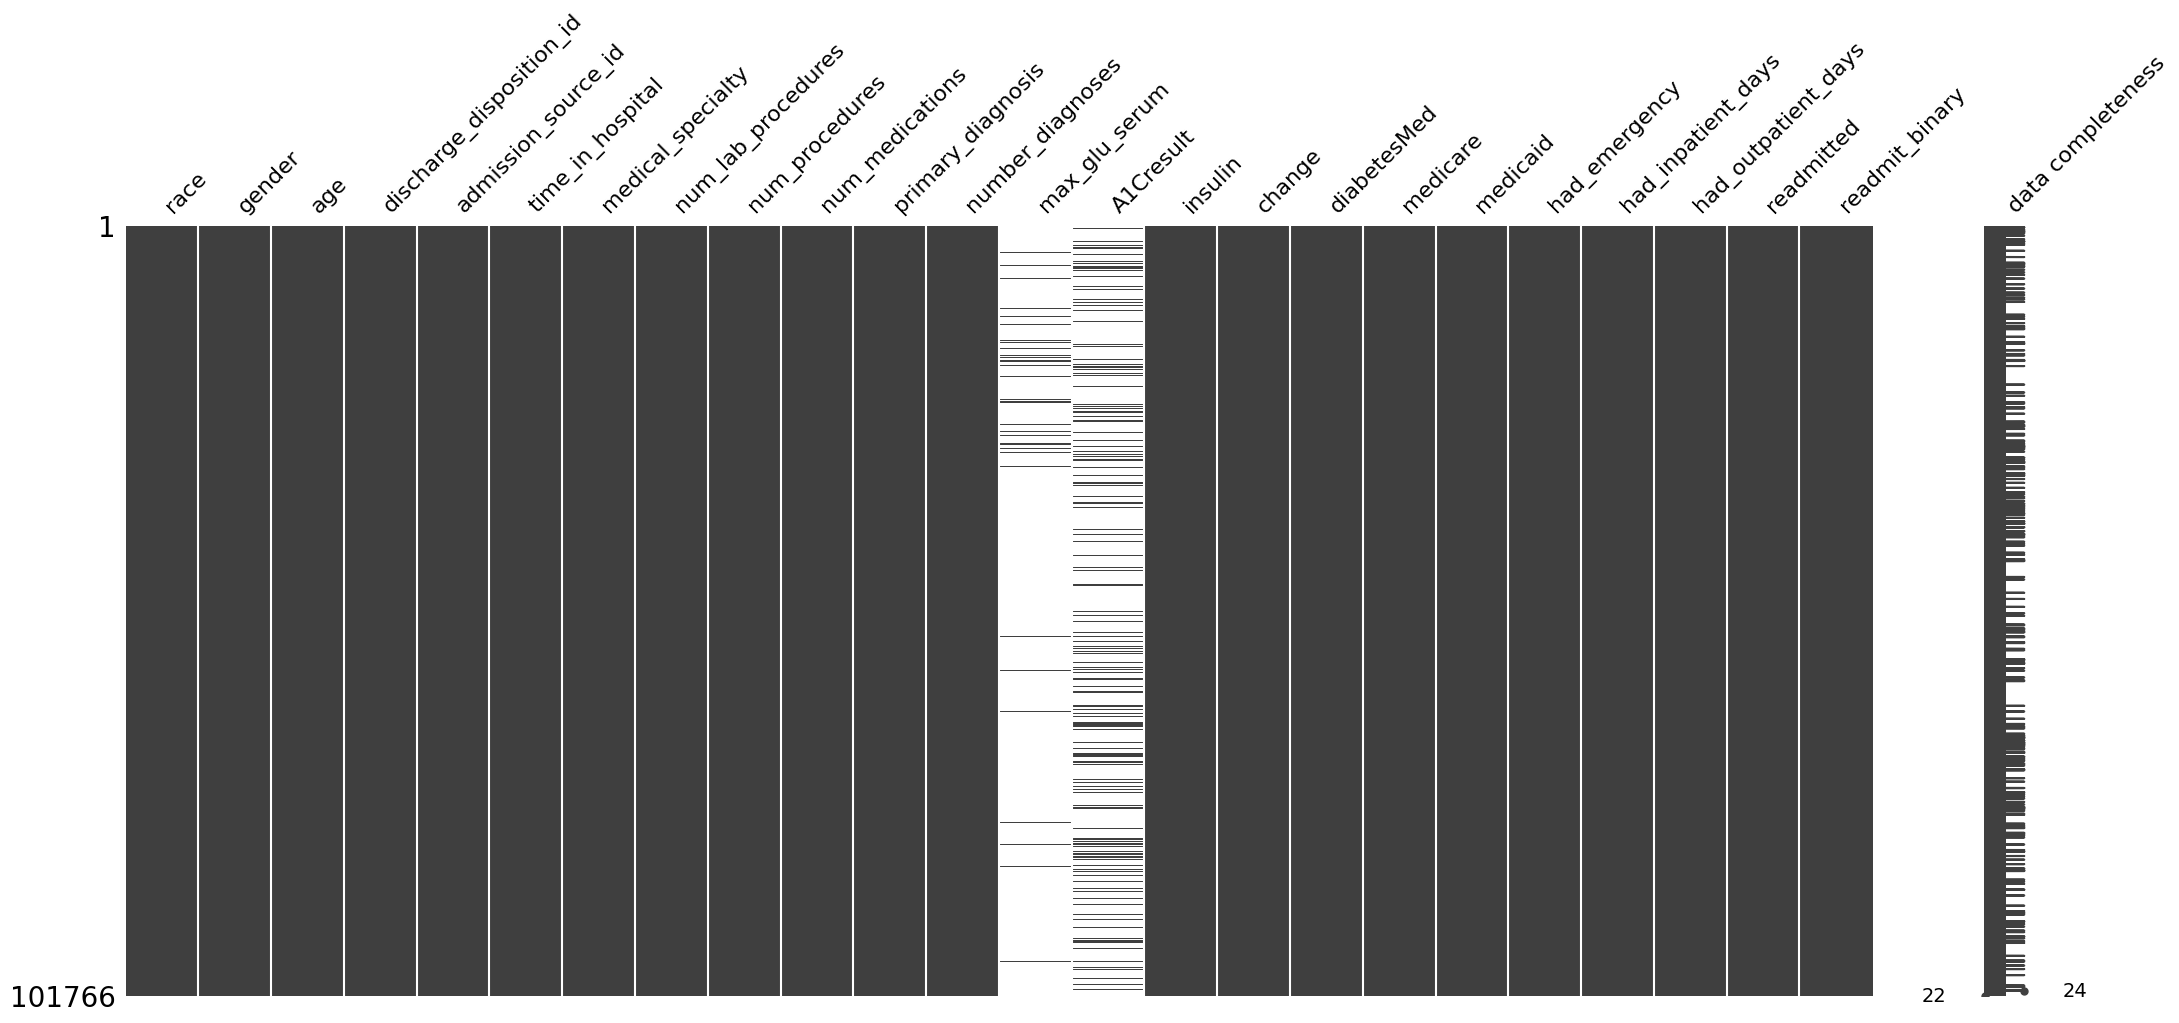

In [6]:
ep.pl.missing_values_matrix(adata)

We see that the dataset contains mostly completely recorded variables, except for `max_glu_serum` and `A1Cresult` variables, which are often missing.

## Selection bias

Selection bias occurs when the data are not representative of the general population, often because the individuals in the dataset are more likely to seek care or have certain conditions.
This can lead to skewed results and incorrect inferences about disease prevalence, treatment effects, or health outcomes.
For example, a study using EHR data from a specialized clinic may overestimate the prevalence of a specific condition because patients visiting the clinic are more likely to have that condition compared to the general population.

### Scenario: Patient Demographics

A popular option in clinical studies is by representing this information in a table:

In [7]:
TableOne(adata.obs)

Missing       Overall
n                                                  101766
race, n (%)   AfricanAmerican             0  19210 (18.9)
              Asian                             641 (0.6)
              Caucasian                      76099 (74.8)
              Hispanic                         2037 (2.0)
              Other                            1506 (1.5)
              Unknown                          2273 (2.2)
gender, n (%) Female                      0  54708 (53.8)
              Male                           47055 (46.2)
              Unknown/Invalid                     3 (0.0)
age, n (%)    '30 years or younger'       0    2509 (2.5)
              '30-60 years'                  30716 (30.2)
              'Over 60 years'                68541 (67.4)

ehrapy allows to represent this information graphically as well:

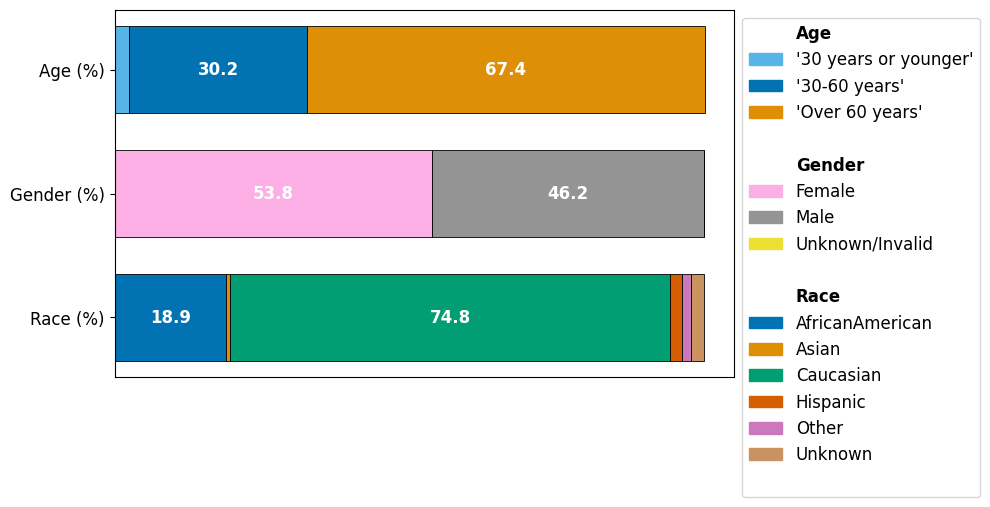

In [8]:
ct = ep.tl.CohortTracker(adata)
ct(adata)
ct.plot_cohort_barplot(
    fontsize=12,
    yticks_labels={"age": "Age (%)", "gender": "Gender (%)", "race": "Race (%)"},
    legend_subtitles=True,
    legend_subtitles_names={"age": "Age", "gender": "Gender", "race": "Race"},
)

We can immediately observe how the different demographics are represented:

- The age group "Over 60 years" is present more frequently than the other age groups "30 years or younger" and "30-60 years".
- The gender groups are balanced, with females forming a slight majority in the dataset. Only 3 visits have a label of "Unknown/Invalid".
- Caucasian are by far the most frequent group. While African American contributes a significant part of the dataset, Asian, Hispanic, Other and Unknown together form less than 7% of the data.

Any analysis take aways may be primarily bias towards characteristics of the Caucasian group if not controlled for.
Notice that a perfect balance does not imply unbiasedness; if a disease is more prevalent among a subgroup, we would expect a non-uniform distribution from a representative dataset.

### Mitigation strategies

- Discuss with data collectors early to ensure that the data collection and sampling process includes a wide range of patient demographics and health conditions if possible.
- Use stratified sampling techniques so that all relevant subgroups are represented according to their real-world distribution.
- Consider dropping groups that are too small and would lead to too small sample sizes when stratified sampling is used (See section "Decision point: How do we address smaller group sizes?" [here](https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/fairness-in-AI-systems-instructors.ipynb): generally be cautious as this can lead to a harm of erasure: be sure to annotate and report this decision).
- Employ propensity score matching to adjust for variables that predict receiving the treatment, thus balancing the data.
- Apply inverse probability weighting (that is, assign more weight to groups infrequently observed) to adjust the influence of observed variables that could lead to selection bias.

Here, **in the later discussed algorithmic bias example we will:**

- merge the three smallest race groups *Asian*, *Hispanic*, *Other* (similar to [Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/))
- drop the gender group *Unknown/Invalid*, because the sample size is so small that no meaningful assessment is possible

## Filtering bias

Filtering bias emerges when the criteria used to include or exclude records in the analysis are unintendedly or unexpectedly filtering for other variables as well, potentially leading to a non-representative sample of the original population.
This bias can obscure the true relationships between variables by systematically removing certain patient groups based on arbitrary or non-transparent criteria.

### Scenario: Medicare

Consider below an example where one filters to the subgroup of *[Medicare](https://www.hhs.gov/answers/medicare-and-medicaid/what-is-the-difference-between-medicare-medicaid/index.html)* recipients.
*Medicare* is only available to people over the age of 65 and younger individuals with severe illnesses.

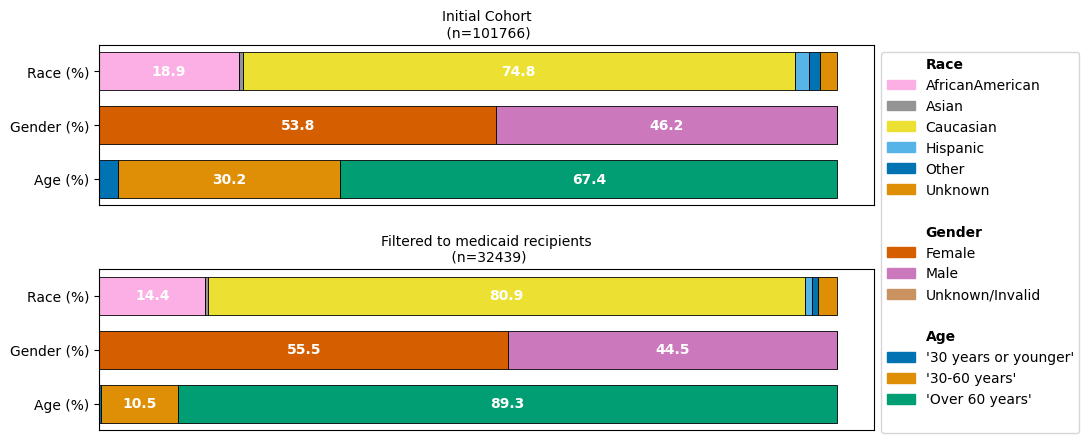

In [9]:
adata_filtered = adata.copy()

ct = ep.tl.CohortTracker(adata_filtered, columns=["age", "gender", "race"])
ct(adata_filtered, label="Initial Cohort")

adata_filtered = adata_filtered[
    adata_filtered.X[:, adata_filtered.var_names == "medicare"] == True
]
ct(adata_filtered, label="Filtered to medicaid recipients")
fig, _ = ct.plot_cohort_barplot(
    subfigure_title=True,
    yticks_labels={"age": "Age (%)", "gender": "Gender (%)", "race": "Race (%)"},
    legend_subtitles=True,
    legend_subtitles_names={"age": "Age", "gender": "Gender", "race": "Race"},
    show=False,
)
fig.subplots_adjust(hspace=0.4)

While we would expect that our medicare-recipients filtered dataset will consist predominantly of patients over 60 years, we might not have expected that the imbalance of the different reported race groups is aggraveted.

### Mitigation strategies

- Explicitly define and consistently apply inclusion and exclusion criteria for the dataset to ensure transparency and reproducibility.
- Document the rationale for all inclusion and exclusion decisions by tracking the cohort.
- Track and report key variables of the patient population representation in the dataset.
- Perform sensitivity analysis for any potentially confounding variables.

## Surveillance bias

Surveillance bias occurs when the likelihood of detecting a condition or outcome is influenced by the intensity or frequency of monitoring, leading to an overestimation of the association between exposure and outcome.
For instance, individuals in a clinical trial may receive more rigorous testing and follow-up compared to the general population, thus appearing to have higher rates of certain conditions or side effects.

### Scenario: Hemoglobin A1c measurement frequency

Hemoglobin A1c (HbA1c) is an important measure of glucose control, which is widely applied to measure performance of diabetes care ([Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

Strack et al. highlight that the measurement of HbA1c at the time of hospital admission offers an opportunity to assess the current diabetes therapy efficacy, but is only done in 18.4% of patients in the inpatient setting.
Here, we can observe that differences between the patient admission type seem to exist: Namely, it appears to be measured more frequently for emergency admissions than for referrals.

In [10]:
ep.ad.move_to_obs(adata, ["A1Cresult", "admission_source_id"], copy_obs=True)
adata.obs["A1Cresult_measured"] = ~adata.obs["A1Cresult"].isna()

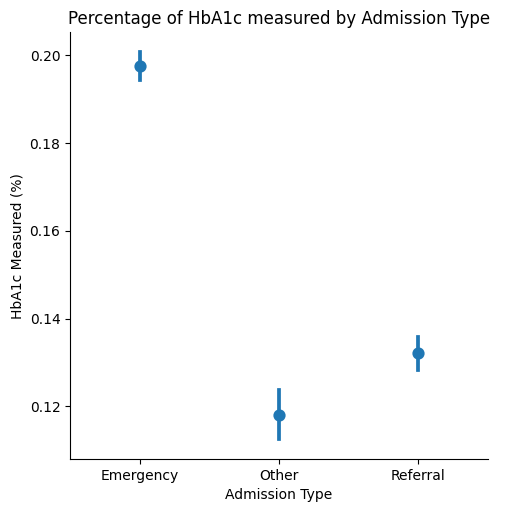

In [11]:
sns.catplot(
    y="A1Cresult_measured",
    x="admission_source_id",
    data=adata.obs,
    kind="point",
    ci=95,
    dodge=True,
    join=False,
)
plt.xlabel("Admission Type")
plt.ylabel("HbA1c Measured (%)")
plt.title("Percentage of HbA1c measured by Admission Type")
plt.show()

### Mitigation strategies

When recording the data:
- Ensure that all groups within the study are monitored with the same frequency and thoroughness, based on standardized clinical protocols.
- Design prospective studies to specify and control the monitoring frequency and methods for all patient cohorts from the outset.
- Apply universal screening or monitoring guidelines across all patient groups to minimize variability in data arising from differential surveillance.


When evaluating the data:
- Use statistical methods to adjust analyses for different levels of surveillance among patient groups, such as stratification or multivariable models that include surveillance intensity as a covariate.
- Take particular care when drawing collective conclusions on patients experiencing different degrees of surveillance.
- Consult the data collectors to learn when and why they record specific values.

## Missing data bias

Missing data bias refers to the distortion in analysis results caused by systematic absence of data points. [Rubin (1976)](https://academic.oup.com/biomet/article-abstract/63/3/581/270932) classified missing data into three categories:
- Missing Completely at Random (MCAR) where the probability of a value being missing is the same for all cases
- Missing at Random (MAR) where the probability of a value being missing is depends on other observed variables
- Missing Not at Random (MNAR) where the probability of a value being missing depends on variables that are not observed

Each type affects the data and subsequent analyses differently, with MCAR having the least impact since the missingness is unrelated to the study variables or outcomes, whereas MAR and NMAR can introduce significant bias in an analysis.
For instance, if patients with more mild symptoms are less likely to have complete records (NMAR), analyses may overestimate the severity and impact of certain conditions.

### Scenario: MCAR and MAR of number of medications

We showcase this bias on the Diabetes-130 dataset, where we introduce missing data in the `num_medications` variable
1. According to an MCAR mechanism
2. According to an MAR mechanism

We first inspect the distribution of the `num_medications` variable:

In [30]:
# reload dataset
adata = ep.dt.diabetes_130_fairlearn()
ep.ad.move_to_obs(adata, ["num_medications", "time_in_hospital"], copy_obs=True)

TableOne(adata.obs, columns=["num_medications"], categorical=[])

,,Missing,Overall
n,,,101766
"num_medications, mean (SD)",,0,16.0 (8.1)


The original dataset does not contain missing values in this variable.
A histogram can give more insight into the distribution of this variable:

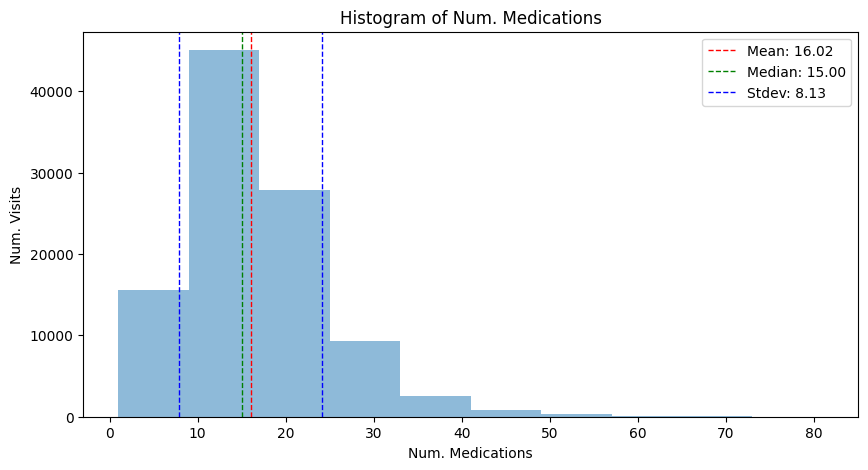

In [31]:
mean_complete, median_complete, std_complete = hist_plot_num_medication(
    adata, "Histogram of Num. Medications", has_missing=False
)

#### MCAR
We now introduce random missingness in the `num_medications` variable, causing 30% of the data to be missing

In [32]:
# create reproducible MCAR missing values
rng = np.random.default_rng(2)
mcar_mask = rng.choice([True, False], size=len(adata), p=[0.3, 0.7])
# create a new AnnData with these missing values
adata_mcar = adata.copy()
adata_mcar.X[mcar_mask, adata_mcar.var_names == "num_medications"] = np.nan

We can visualize the degree of missingness:

<Axes: >

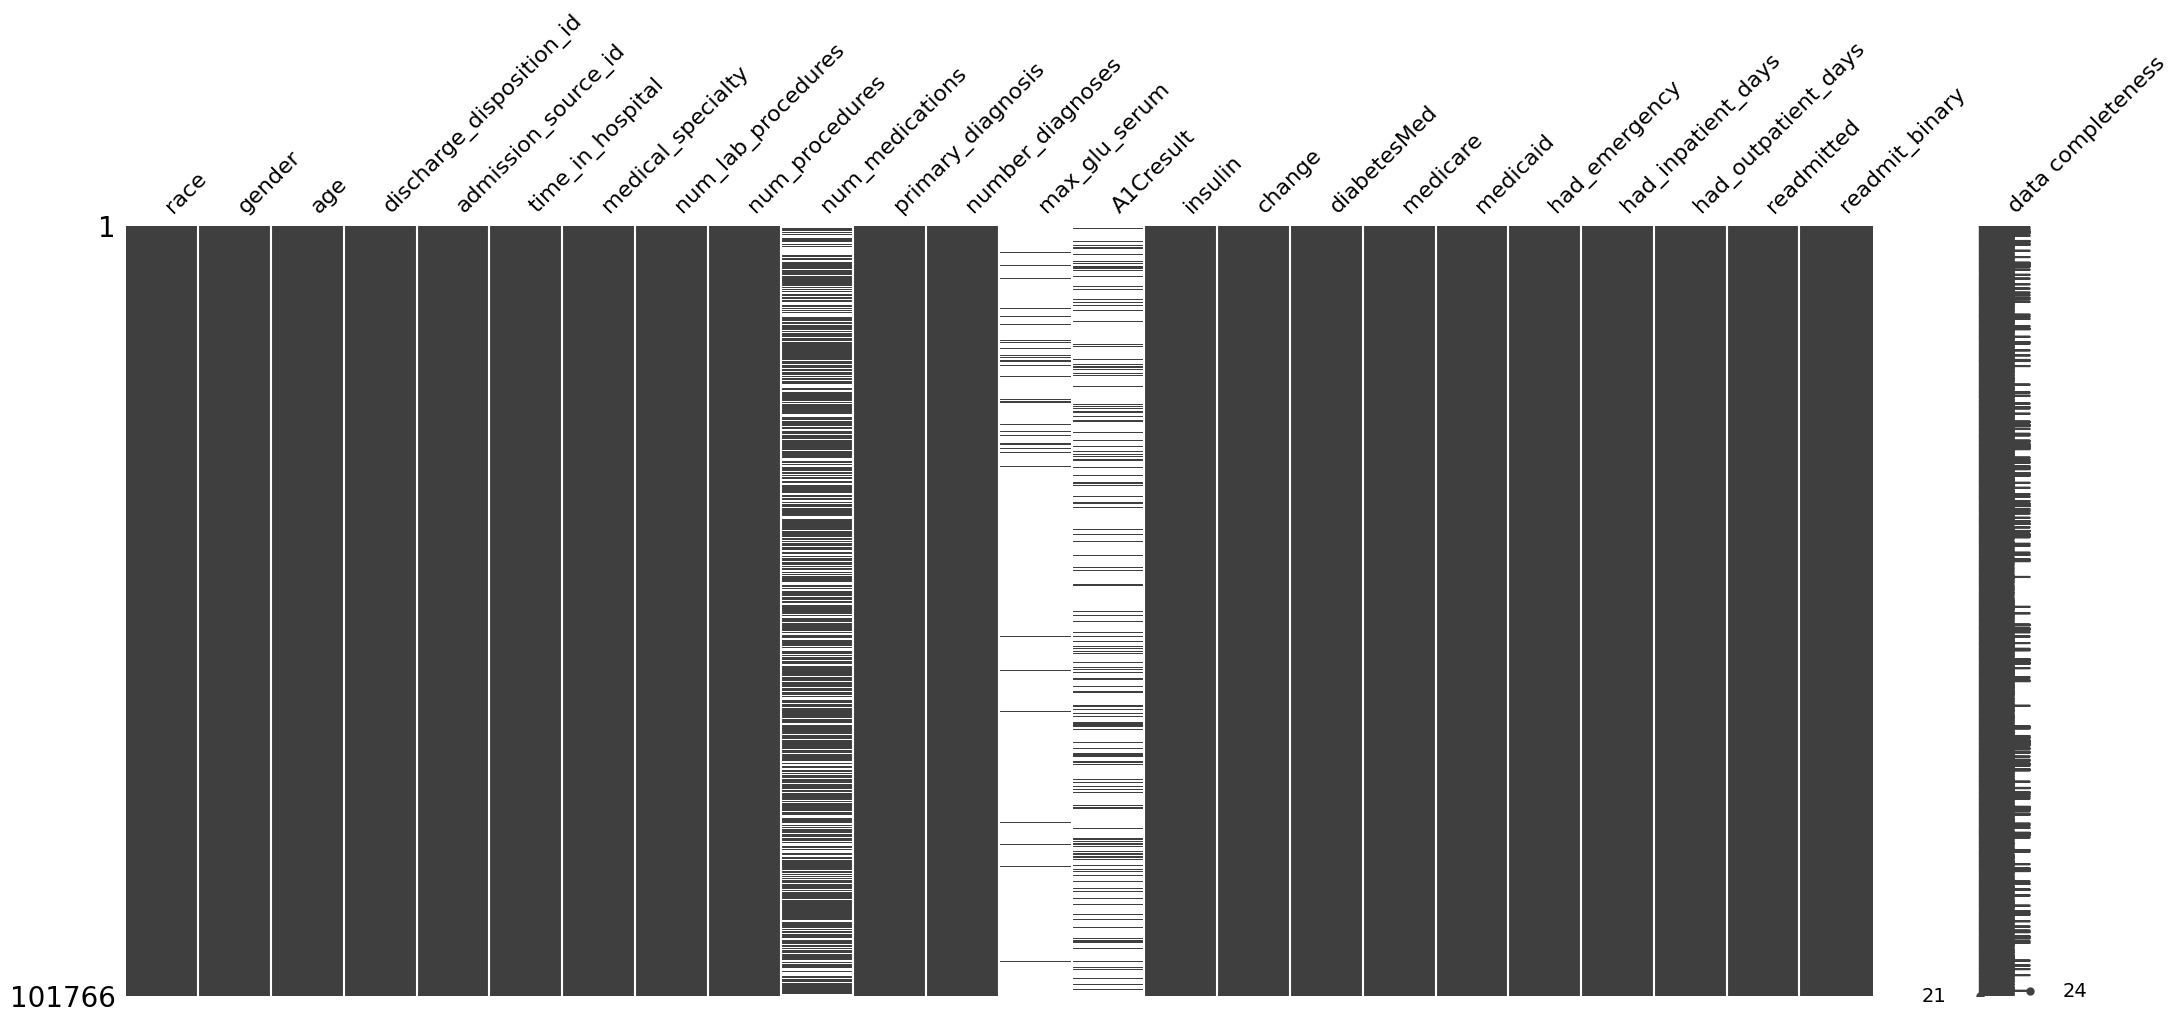

In [33]:
ep.pl.missing_values_matrix(adata_mcar)

We can see that under the MCAR mechanism, the shape of the distribution, its mean and its variance here do not systematically deviate:

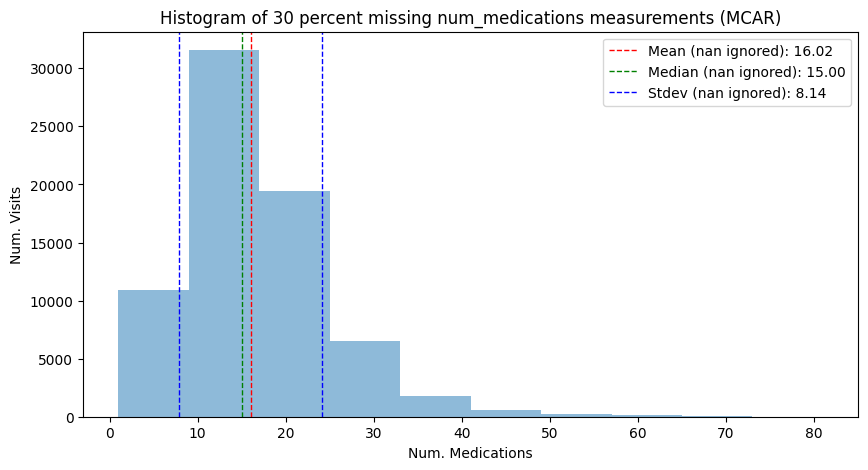

In [34]:
mean_mcar, median_mcar, std_mcar = hist_plot_num_medication(
    adata_mcar,
    "Histogram of 30 percent missing num_medications measurements (MCAR)",
    has_missing=True,
)

In [35]:
summary_stats_df = pd.DataFrame(
    {
        "Complete": [mean_complete, median_complete, std_complete],
        "MCAR": [mean_mcar, median_mcar, std_mcar],
    },
    index=["Mean", "Median", "Stdev"],
)
summary_stats_df.round(2)

,Complete,MCAR
Mean,16.02,16.02
Median,15.00,15.00
Stdev,8.13,8.14


[Little's MCAR test](https://www.tandfonline.com/doi/abs/10.1080/01621459.1988.10478722) is a statistical test, with the null hypothesis being that the data is MCAR.
Care is to be taken when interpreting such results, as the practical value of such statistical tests is still under discussion [van Buuren (2018)](https://stefvanbuuren.name/fimd/).
We consider the relationship of two variables of interest in this example:

In [36]:
pvalue = ep.pp.mcar_test(
    adata_mcar[:, adata_mcar.var_names.isin(["num_medications", "time_in_hospital"])]
)
print(f"pvalue of Little's MCAR test: {pvalue:.2f}")

pvalue of Little's MCAR test: 0.71


With a p-value of 0.71, we obtain no indication of the data being not MCAR: its important to note that this is not a prove of the data being MCAR. Rather, low p-values should spark attention in particular. See [Schouten 2021](https://journals.sagepub.com/doi/full/10.1177/0049124118799376) for more details.

#### MAR

We now introduce MNAR in the `num_medications` variable.
We use `time_in_hospital` to have an impact on the probability of the `num_medications` variable by generating a synthetic example where the probability of the `num_medications` variable being missing is larger, the longer the `time_in_hospital` is.
This simulates a situation where the medication sheet would get lost at one point during the patients stay, with longer stays making it more probable to have the sheet lost somewhen along the way.

In [54]:
# Scale the time_in_hospital variable
continuous_values = np.array(
    adata.obs["time_in_hospital"] - np.mean(adata.obs["time_in_hospital"])
) / np.std(adata.obs["time_in_hospital"])
# small offset to steer the degree of missingness
continuous_values -= 0.7

# Convert continuous values to probabilities using the logistic function
probabilities = 1 / (1 + np.exp(-continuous_values))
probabilities

# Generate MAR mask based on probabilities
rng = np.random.default_rng(2)
mar_mask = rng.binomial(1, probabilities).astype(bool)

adata_mar = adata.copy()
adata_mar.X[mar_mask, adata_mar.var_names == "num_medications"] = np.nan

We can visualize the degree of introduce missingness:

<Axes: >

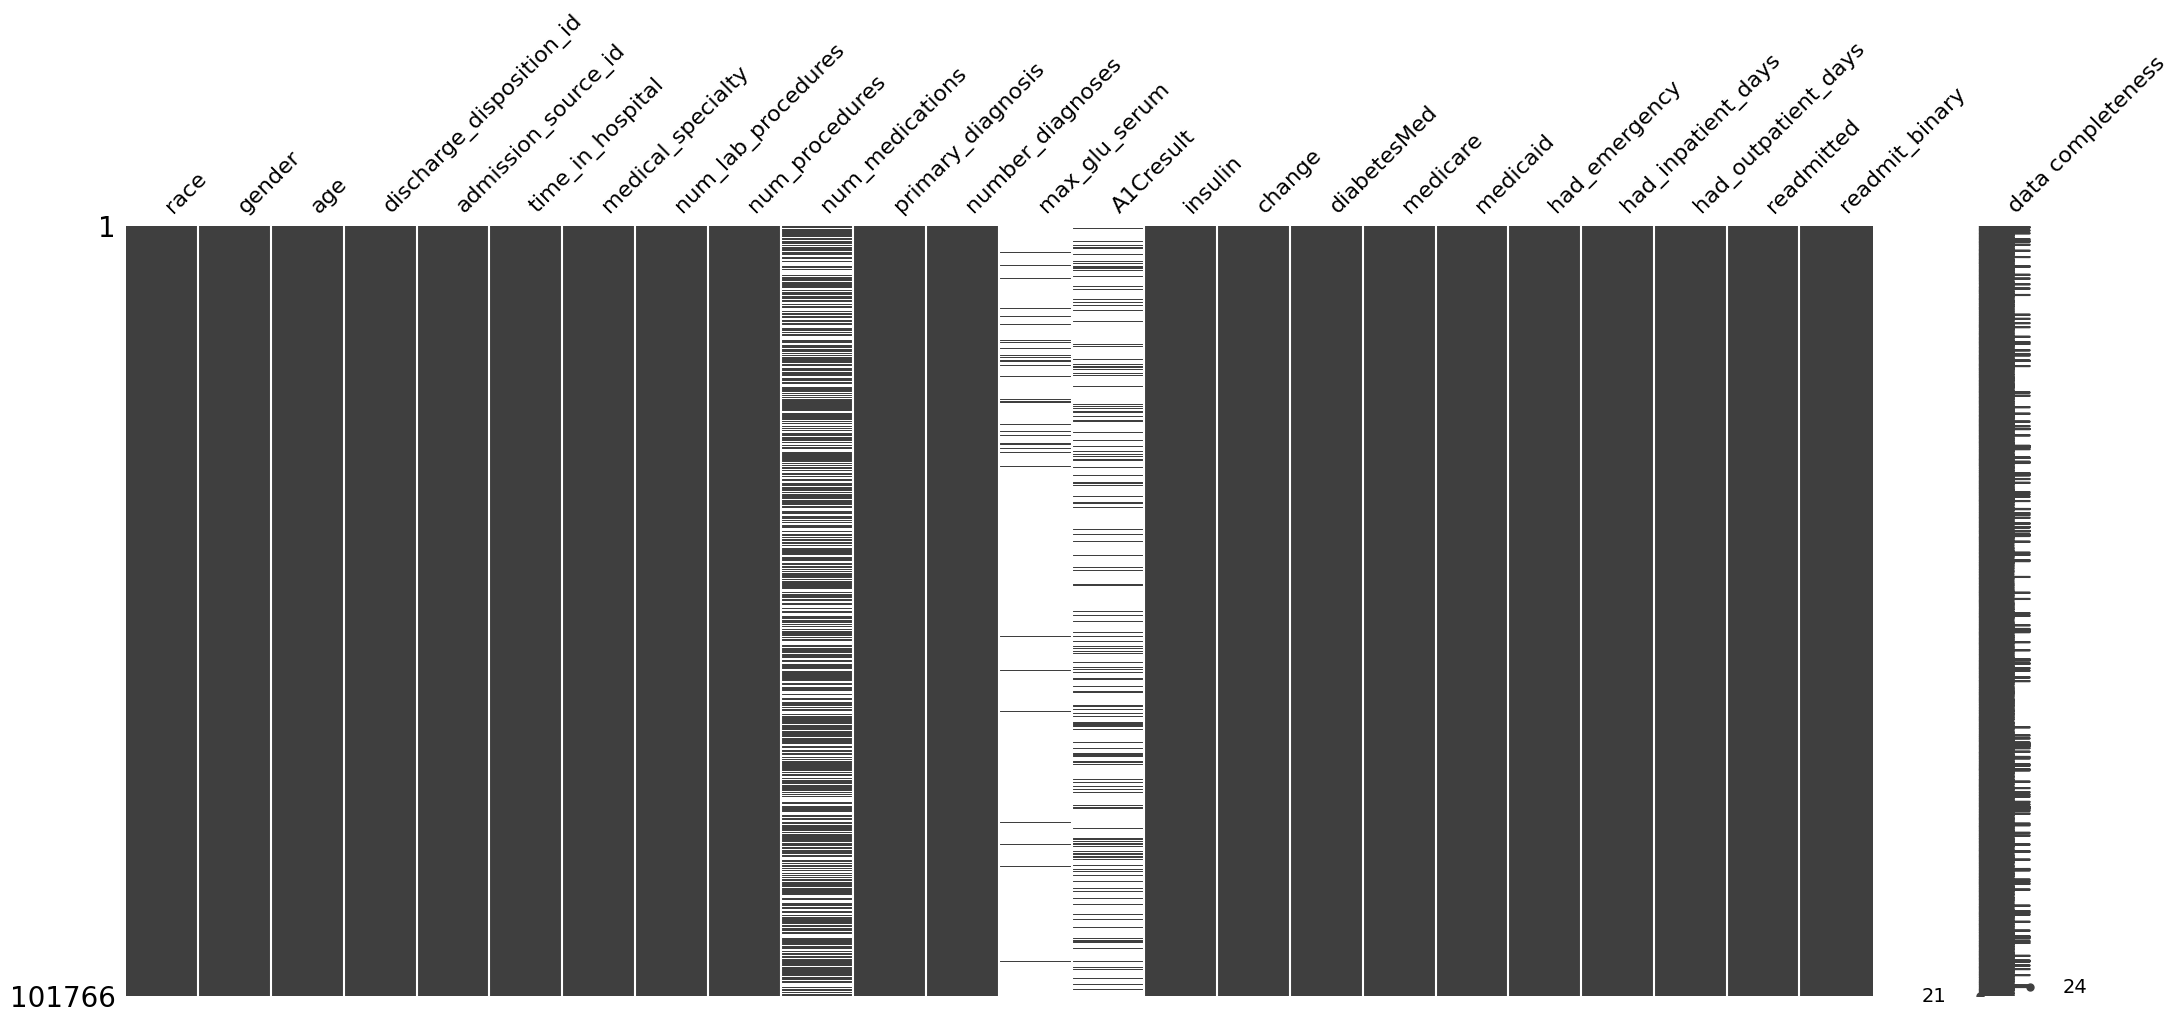

In [53]:
ep.pl.missing_values_matrix(adata_mar)

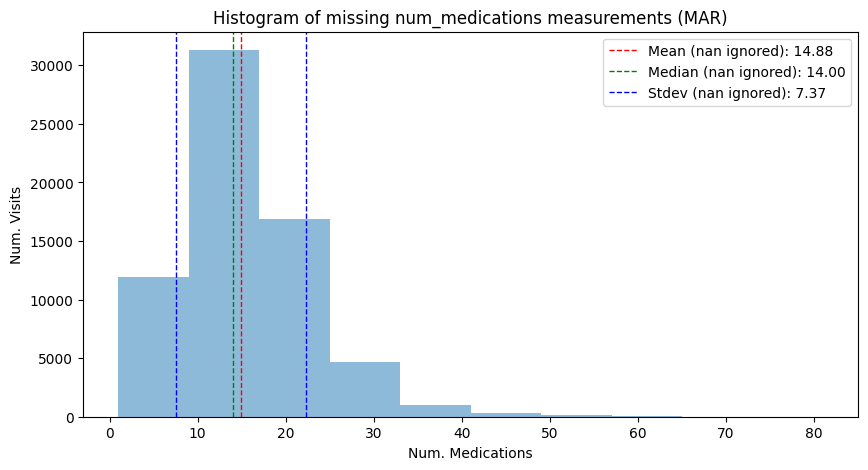

In [39]:
mean_mar, median_mar, std_mar = hist_plot_num_medication(
    adata_mar,
    "Histogram of missing num_medications measurements (MAR)",
    has_missing=True,
)

In [40]:
summary_stats_df["MAR"] = [mean_mar, median_mar, std_mar]
summary_stats_df.round(2)

,Complete,MCAR,MAR
Mean,16.02,16.02,14.88
Median,15.00,15.00,14.00
Stdev,8.13,8.14,7.37


We can see that under the MAR mechanism, the shape of the distribution, its mean and its variance do systematically deviate from the complete case.
This is different from the MCAR case.
The mean and median droppped from 16.02 and 15.00 to 14.54 and 14.00, respectively. Also, the standard deviation changed form 8.13 to 7.14.

Such a scenario illustrates that we do have interest in imputing missing data, in a meaningful way.

We can again use Little's Test to evaluate the missing data behaviour between our two variables of interest, on our synthetic MAR data:

In [41]:
pvalue = ep.pp.mcar_test(
    adata_mar[:, adata_mar.var_names.isin(["num_medications", "time_in_hospital"])]
)
print(f"pvalue of Little's MCAR test: {pvalue:.2f}")

pvalue of Little's MCAR test: 0.00


Here, the pvalue of (rounded) 0.00 according to Little's Test should make us reject our Null Hypothesis being the data is MCAR with respect to these two variables: Indeed, we know by our constructed example that the data is missing according to an MAR mechanism between these two variables.

### Mitigation strategies

There is a lot of literature on missing data for a first dive into more details such as [van Buuren (2018)](https://stefvanbuuren.name/publication/vanbuuren-2018/), [Schouten 2021](https://journals.sagepub.com/doi/full/10.1177/0049124118799376).

- Determine the type of missing data (MCAR, MNAR, MAR) if possible.
- Improve data collection processes to reduce the occurrence of missing data, including training for healthcare providers on the importance of complete data entry.
- Consider data augmentation strategies, such as linking EHR data with other databases (e.g., insurance claims, registries) to fill gaps.
- Prevention of the missing data is the most direct handle on problems caused by the missing data.
- Visualize missing data patterns with ehrapy to get an intuition of potential confounders and dependencies.

Many algorithms require dense matrices without missing data.
Therefore, a common task is imputing the missing data which can lead to further biases that are discussed next.

## Imputation bias

Imputation bias, a specific form of algorithmic bias, occurs when the process used to estimate and fill in (impute) missing values introduces systematic differences between the imputed values and the true values.

When the data is MCAR, mean, median, or mode imputation for continuous variables does not introduce systematic bias to these statistics of the overall distribution of this continuous variable.
However, it commonly introduces an underestimation of the variance of the data.
In the MAR case, mean imputation of continuous variables introduces bias into the overall distribution of the variable: both its location and variance can be significantly biased.

See [van Buuren (2018)](https://stefvanbuuren.name/fimd/) for a detailed discussion.

We showcase this bias on the Diabetes-130 dataset, where we introduced missing data in the `num_medications` variable in the section before:

1. According to an MCAR mechanism
2. According to an MAR mechanism

### Scenario: Mean Imputation in the MCAR case

We start off by showcasing mean imputation's behaviour in the MCAR setting. We first perform a simple mean imputation on our `num_medications` variable, and consider the new distribution with a histogram:

In [42]:
adata_mcar_mean_imputed = ep.pp.simple_impute(
    adata_mcar, var_names=["num_medications"], strategy="mean", copy=True
)

Output()

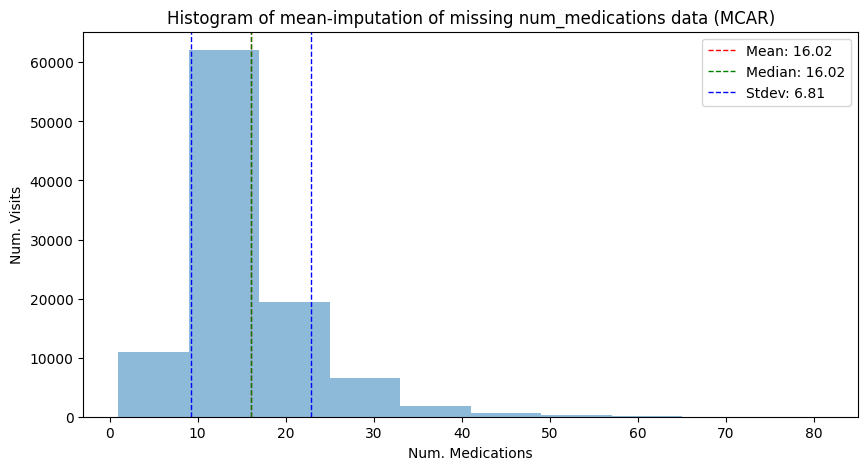

In [43]:
mean_mn_imp, median_mn_imp, std_mn_imp = hist_plot_num_medication(
    adata_mcar_mean_imputed,
    "Histogram of mean-imputation of missing num_medications data (MCAR)",
    has_missing=False,
)

In [44]:
summary_stats_df["Mean Imputation (MCAR)"] = [mean_mn_imp, median_mn_imp, std_mn_imp]
summary_stats_df.round(2)

,Complete,MCAR,MAR,Mean Imputation (MCAR)
Mean,16.02,16.02,14.88,16.02
Median,15.00,15.00,14.00,16.02
Stdev,8.13,8.14,7.37,6.81


We can see immediately how the overall location of the distribution is not affected by mean imputation in the MCAR case (even though the median might have tipped): however, we can see that the variance now gets severly underestimated: the standard deviation dropped from to 8.1 in the original data to 6.8 in the imputed data.

### Scenario: Mean Imputation in the MAR case

We now consider the MAR case from the previous section on missing data. We first perform a simple mean imputation on our `num_medications` variable, and consider the new distribution with a histogram:

In [45]:
adata_mar_mean_imputed = ep.pp.simple_impute(
    adata_mar, var_names=["num_medications"], strategy="mean", copy=True
)

Output()

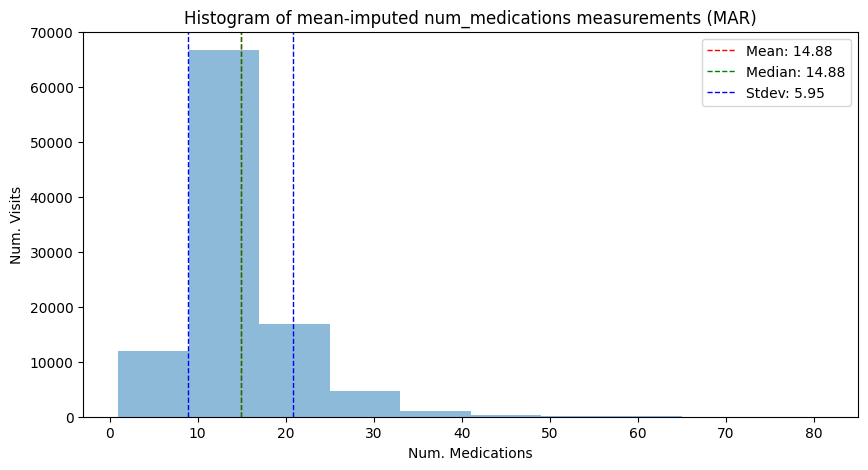

In [46]:
mean_mn_imp_mar, median_mn_imp_mar, std_mn_imp_mar = hist_plot_num_medication(
    adata_mar_mean_imputed,
    "Histogram of mean-imputed num_medications measurements (MAR)",
    has_missing=False,
)

In [47]:
summary_stats_df["Mean Imputation (MAR)"] = [
    mean_mn_imp_mar,
    median_mn_imp_mar,
    std_mn_imp_mar,
]
summary_stats_df.round(2)

,Complete,MCAR,MAR,Mean Imputation (MCAR),Mean Imputation (MAR)
Mean,16.02,16.02,14.88,16.02,14.88
Median,15.00,15.00,14.00,16.02,14.88
Stdev,8.13,8.14,7.37,6.81,5.95


The mean imputation, which yielded a valid estimate of the mean in the MCAR case, now is not a valid imputation anymore; both the location and the variance of the mean imputed dataset are skewed compared to the original data.

Now, more sophisticated approaches are needed: e.g. Multiple imputation has been shown to [perform well for MAR data](https://www.frontiersin.org/articles/10.3389/fdata.2021.693674/full).
Here, we apply one such strategy, the [MissForest imputation](https://academic.oup.com/bioinformatics/article/28/1/112/219101), as implemented in ehrapy:

In [48]:
# consider for imputation only the two variables of our focus
adata_mar_medication_hospital_time = AnnData(
    adata_mar[
        :, adata_mar.var_names.isin(["time_in_hospital", "num_medications"])
    ].X.copy().astype(np.float64),
)
adata_mar_medication_hospital_time.var_names = ["time_in_hospital", "num_medications"]
ep.ad.infer_feature_types(adata_mar_medication_hospital_time)

adata_mar_medication_hospital_time_imputed = ep.pp.miss_forest_impute(adata_mar_medication_hospital_time, copy=True)

2024-04-26 10:04:21,425 - root INFO - Stored feature types in adata.var['feature_type']. Please verify and adjust if necessary using adata.var['feature_type']['feature1']='corrected_type'.


 Detected feature types for AnnData object with 101766 obs and 2 vars
╠══ 📅 Date features
╠══ 📐 Numerical features
║   ╚══ num_medications
╚══ 🗂️ Categorical features
    ╚══ time_in_hospital (14 categories)

Output()

The number of jobs is only 1. To decrease the runtime set ep.settings.n_jobs=-1.

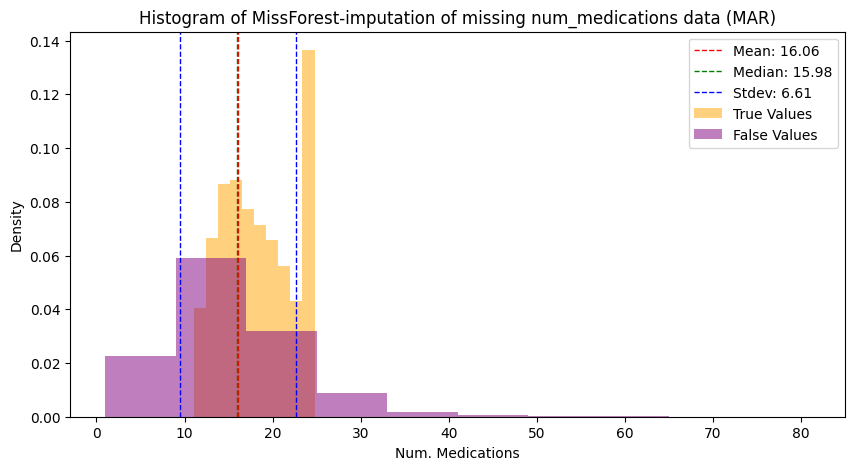

In [55]:
mean_mf_imp_mar, median_mf_imp_mar, std_mf_imp_mar = hist_plot_num_medication(
    adata_mar_medication_hospital_time_imputed,
    "Histogram of MissForest-imputation of missing num_medications data (MAR)",
    has_missing=False,
)

In [50]:
summary_stats_df["MissForest Imputation (MAR)"] = [
    mean_mf_imp_mar,
    median_mf_imp_mar,
    std_mf_imp_mar,
]
summary_stats_df.round(2)

,Complete,MCAR,MAR,Mean Imputation (MCAR),Mean Imputation (MAR),MissForest Imputation (MAR)
Mean,16.02,16.02,14.88,16.02,14.88,16.06
Median,15.00,15.00,14.00,16.02,14.88,15.98
Stdev,8.13,8.14,7.37,6.81,5.95,6.61


Comparing the change in location (median, scale) and variance of the non-imputed data and the mean imputed data, MissForest imputation shows superior results for the harder MAR case to Mean Imputation.

Importantly, imputation is not about "recreating the lost data", but about being able to make valid inference from the incomplete data [van Buuren (2018)](https://stefvanbuuren.name/fimd/).
The behaviour of skewed location and variance in the data distribution here demonstrates how imputation methods under different missing data models can manifest biases in our analyses.

### Mitigation Strategies

As mentioned in the missing data section, extensive literature on missing data and imputation is available.
For a first dive into more details e.g. [van Buuren (2018)](https://stefvanbuuren.name/publication/vanbuuren-2018/), [Schouten 2021](https://journals.sagepub.com/doi/full/10.1177/0049124118799376) can be considered.

- Conduct thorough exploratory analysis to understand the patterns and mechanisms of missing data, helping to guide the choice of the most appropriate imputation method.
- Select imputation methods that best fit the data distribution and the mechanism of missingness. Multiple imputation methods have been shown to perform well under many circumstances.
- Validate the imputation model by comparing the characteristics of the imputed data with the observed data, ensuring that the imputation process does not significantly alter the data distribution.
- Avoid imputation in cases of high proportions of missing data where the imputation might dominate the analytical results, potentially leading to biased outcomes.
- Use robustness checks, such as repeating the analysis with different imputation methods or omitting imputation altogether (using sparse matrices), to assess the impact of the imputation on the study conclusions.
- Be wary of clusters in the data that have high percentage of missing data.

## Algorithmic bias

Algorithmic bias occurs when algorithms systematically perform better for certain groups than for others, often due to biases inherent in the data used to train these algorithms.
This can result in unequal treatment recommendations, risk predictions, or health outcomes assessments across different demographics, such as race, gender, or socioeconomic status.
For instance, an algorithm trained predominantly on data from one ethnic group may perform poorly or inaccurately predict outcomes for individuals from underrepresented groups, exacerbating disparities in healthcare access and outcomes.

### Scenario: Recommending patients for high-risk care management programs

Here, we adapt an example from the [Fairlearn SciPy 2021 Tutorial: Fairness in AI Systems](https://github.com/fairlearn/talks/tree/main/2021_scipy_tutorial).

We predict **hospital readmission within 30 days** from the earlier introduced dataset of hospital data of diabetic patients.
Such a quick readmission is viewed as proxy that the patient needed more assistance at release time and is therefore our target variable.

We follow the decision in the earlier work to measure the:
- balanced accuracy to investigate the performance of the algorithm
- selection rate to investigate how many patients are recommended for care
- false negative rate to investigate how many patients would have missed the needed assistance

An investigation is needed to determine whether any patient subgroups within the demographic variable `race` are negatively affected by a model.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.metrics import MetricFrame, false_negative_rate, selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

#### Data Preparation
We load the dataset, and put variables we don't want to pass to our model into the `.obs` field.
We build a binary label `readmit_30_days` indicating whether a patient has been readmitted in <30 days.

In [5]:
adata_algo = ep.dt.diabetes_130_fairlearn(
    columns_obs_only=[
        "race",
        "gender",
        "age",
        "readmitted",
        "readmit_binary",
        "discharge_disposition_id",
    ]
)
adata_algo.obs["readmit_30_days"] = adata_algo.obs["readmitted"] == "<30"

In our dataset, our patients are predominantly *Caucasian* (75%). The next largest racial group is *AfricanAmerican*, making up 19% of the patients. The remaining race categories (including *Unknown*) compose only 6% of the data.
In this dataset, gender is primarily reported binary, with 54% *Female* and 46% *Male*, and 3 samples annotated as *Unknown/Invalid*

In [6]:
TableOne(adata_algo.obs, columns=["race", "gender", "age"])

Missing       Overall
n                                                  101766
race, n (%)   AfricanAmerican             0  19210 (18.9)
              Asian                             641 (0.6)
              Caucasian                      76099 (74.8)
              Hispanic                         2037 (2.0)
              Other                            1506 (1.5)
              Unknown                          2273 (2.2)
gender, n (%) Female                      0  54708 (53.8)
              Male                           47055 (46.2)
              Unknown/Invalid                     3 (0.0)
age, n (%)    '30 years or younger'       0    2509 (2.5)
              '30-60 years'                  30716 (30.2)
              'Over 60 years'                68541 (67.4)

#### Decision: How to address smaller group sizes?
We have seen different strategies to address smaller group sizes in the selection bias part.

- For the `race` variable, we will follow the strategy of using buckets to merge small groups *Other*, *Spanish*, *Asian*.
- For the `gender` variable, we will remove the *Unknown/Invalid* annotated samples, as no meaningful assessment is possible with this sample size

In [7]:
# aggregate small groups
adata_algo.obs["race_all"] = adata_algo.obs["race"]
adata_algo.obs["race"] = adata_algo.obs["race"].replace(
    {"Asian": "Other", "Hispanic": "Other"}
)

# drop gender group Unknown/Invalid
adata_algo = adata_algo[adata_algo.obs["gender"] != "Unknown/Invalid", :].copy()
ep.ad.move_to_x(adata_algo, "gender")

2024-04-17 23:03:23,799 - root INFO - Added `['gender']` features to `X`.


AnnData object with n_obs × n_vars = 101763 × 19
    obs: 'race', 'age', 'readmitted', 'readmit_binary', 'discharge_disposition_id', 'readmit_30_days', 'race_all'
    var: 'ehrapy_column_type'

We now prepare our variables required for model training, and encode categorical variables in the data.

In [8]:
adata_algo = ep.pp.encode(
    adata_algo,
    autodetect=True,
)

2024-04-17 23:03:25,463 - root INFO - The original categorical values `['admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']` were added to uns.


Output()

2024-04-17 23:03:26,315 - root INFO - Updated the original layer after encoding.


2024-04-17 23:03:26,496 - root INFO - The original categorical values `['admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']` were added to obs.


We split our data into train and test groups.

In [9]:
train_idxs, test_idxs = train_test_split(
    np.arange(adata_algo.n_obs),
    stratify=adata_algo.obs["race"],
    test_size=0.5,
    random_state=0,
)
adata_algo_train = adata_algo[train_idxs, :]
adata_algo_test = adata_algo[test_idxs, :]

In [10]:
adata_algo_train.obs["readmit_30_days"].value_counts()

readmit_30_days
False    45214
True      5667
Name: count, dtype: int64

To account for label imbalance of our target variable `readmit_30_days` with more `False` than `True` cases, we do balanced subsampling by performing [Random Undersampling](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html):

In [11]:
adata_algo_train_balanced = ep.pp.balanced_sample(
    adata_algo_train,
    key="readmit_30_days",
    method="RandomUnderSampler",
    random_state=0,
    copy=True,
)
adata_algo_train_balanced.obs["readmit_30_days"].value_counts()

readmit_30_days
False    5667
True     5667
Name: count, dtype: int64

#### Model Training

In [13]:
unmitigated_pipeline = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("logistic_regression", LogisticRegression(max_iter=1000)),
    ]
)

In [14]:
unmitigated_pipeline.fit(
    adata_algo_train_balanced.X,
    adata_algo_train_balanced.obs["readmit_30_days"].astype(bool),
)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

We can inspect our model's coefficients:

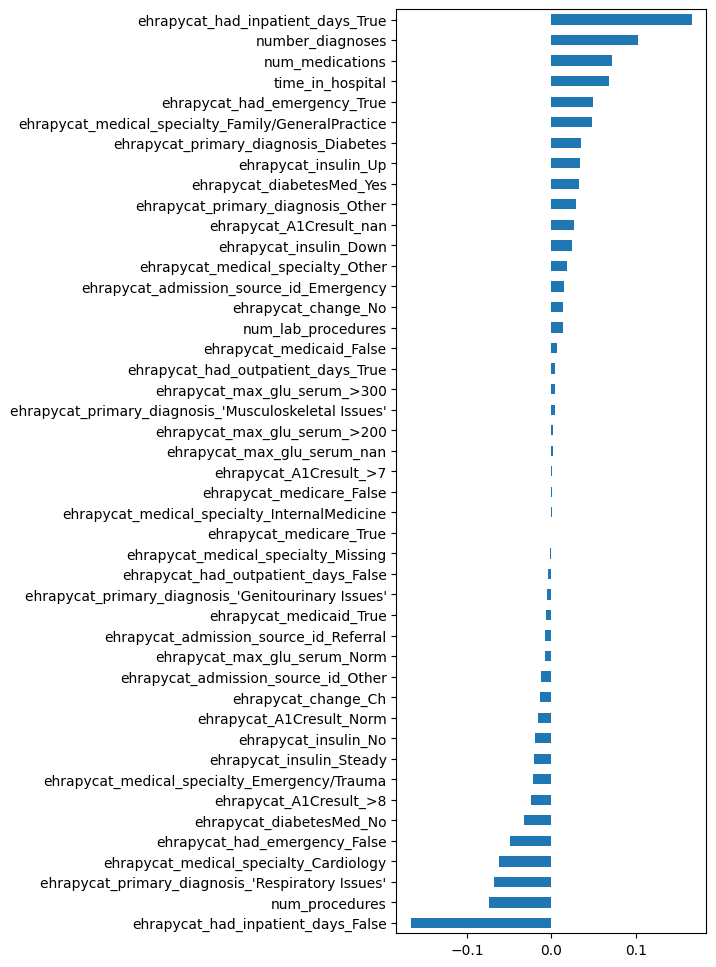

In [15]:
coef_series = pd.Series(
    data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0],
    index=adata_algo_train_balanced.var_names,
)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

To check our model performance on the test data, we first look at the ROC curve of this binary classifier:

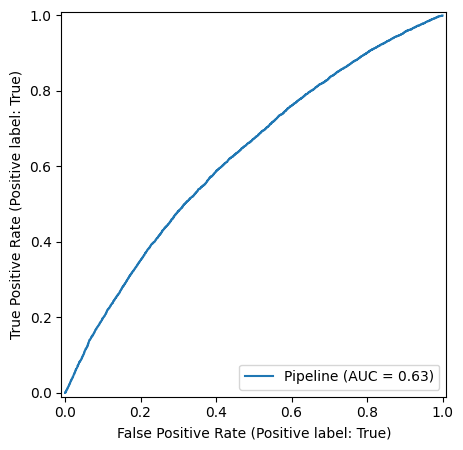

In [16]:
Y_pred_proba = unmitigated_pipeline.predict_proba(adata_algo_test.X)[:, 1]
Y_pred = unmitigated_pipeline.predict(adata_algo_test.X)

RocCurveDisplay.from_estimator(unmitigated_pipeline, adata_algo_test.X, adata_algo_test.obs["readmit_30_days"].astype(bool));

We observe an overall balanced accuracy of 0.59, well about random chance, albeit showing that the simplified model and assumptions are far from a reliable prediction.

In [17]:
balanced_accuracy_score(adata_algo_test.obs["readmit_30_days"].astype(bool), Y_pred.astype(bool))

Using fairlearn's MetricFrame utility, we can conveniently inspect our target model performance measurements:

In [18]:
metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

mf1 = MetricFrame(
    metrics=metrics_dict,
    y_true=adata_algo_test.obs["readmit_30_days"],
    y_pred=Y_pred,
    sensitive_features=adata_algo_test.obs["race"],
)

mf1.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.400833,0.419385,0.601196
Caucasian,0.382129,0.461288,0.588269
Other,0.321224,0.483568,0.608668
Unknown,0.231718,0.611650,0.586132


A barplot represents this information graphically:

array([[<Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

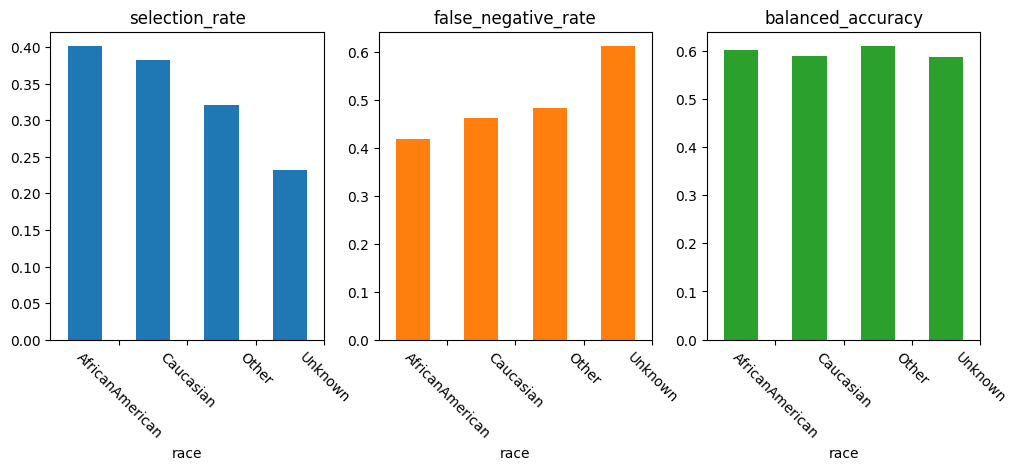

In [19]:
mf1.by_group.plot.bar(
    subplots=True, layout=[1, 3], figsize=(12, 4), legend=False, rot=-45, position=1.5
)

We can observe that performance is worst for the "Other" and "Unkown" subgroups across all metrics.
Particularly relevant with respect to fairlearn's conception of fairness as harming a subgroup, the low selection rate and the worse False Negative rate in this smaller subgroups is highly relevant:

The model is biased towards a worse performance of these groups.

#### Mitigation: fairlearn's ThresholdOptimizer

Towards a mitigation, we instantiate ThresholdOptimizer with the logistic regression estimator:

In [21]:
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)
postprocess_est.fit(
    adata_algo_train_balanced.X, adata_algo_train_balanced.obs["readmit_30_days"], sensitive_features=adata_algo_train_balanced.obs["race"]
)
Y_pred_postprocess = postprocess_est.predict(adata_algo_test.X, sensitive_features=adata_algo_test.obs["race"])
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=adata_algo_test.obs["readmit_30_days"],
    y_pred=Y_pred_postprocess,
    sensitive_features=adata_algo_test.obs["race"],
)
pd.concat(
    [mf1.by_group, metricframe_postprocess.by_group],
    keys=["Unmitigated", "ThresholdOptimizer"],
    axis=1,
)

Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican       0.400833            0.419385          0.601196   
Caucasian             0.382129            0.461288          0.588269   
Other                 0.321224            0.483568          0.608668   
Unknown               0.231718            0.611650          0.586132   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican           0.374076            0.448276          0.599995  
Caucasian                 0.400972            0.438735          0.590360  
Other                     0.386233            0.427230          0.603841  
Unknown                   0.407048            0.398058          0.607172

In [23]:
Y_pred_mitig = postprocess_est.predict(adata_algo_test.X, sensitive_features=adata_algo_test.obs["race"])
balanced_accuracy_score(adata_algo_test.obs["readmit_30_days"].astype(bool), Y_pred_mitig.astype(bool))

array([[<Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

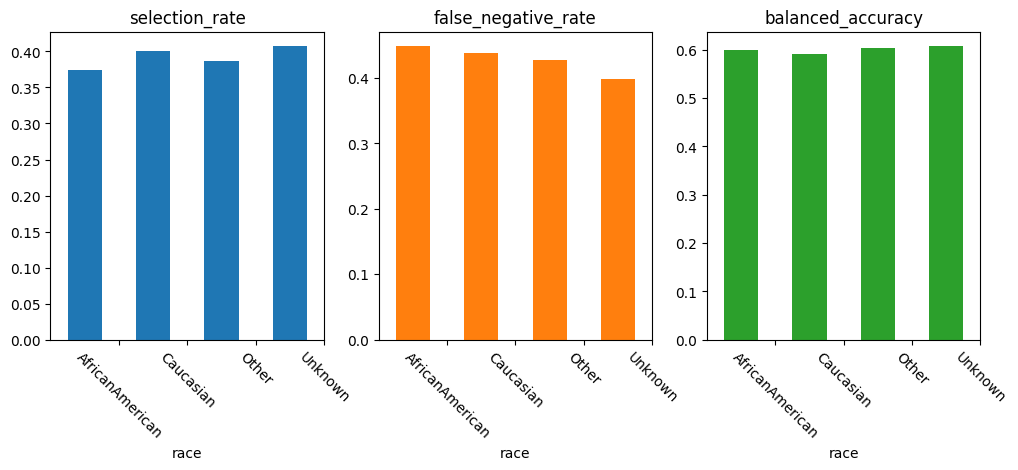

In [24]:
metricframe_postprocess.by_group.plot.bar(
    subplots=True, layout=[1, 3], figsize=(12, 4), legend=False, rot=-45, position=1.5
)

We can observe that the performance especially across the subgroups under-represented in the dataset could be enhanced.
In particular, the false negative rate, predicting patients of particular need to not belong to this class, could be increased for the underrepresented groups.

### Mitigation Strategies

- Engage diverse stakeholders, including ethicists and representatives from impacted groups, during the algorithm development and review process to provide perspectives on potential bias.
- Ensure the training data for algorithms includes a diverse and representative sample of the population, covering various demographics to prevent skewed model outcomes.
- Validate model outcomes across different demographic groups to ensure that the algorithm performs equitably before it is used widely in clinical settings.
- Maintain transparency in algorithm development and deployment processes, with clear documentation of decision criteria, data sources, and modeling techniques.
- Conduct regular audits of algorithm performance to check for biases, involving external audits if possible to ensure impartiality.
- Validate model outcomes across different demographic groups to ensure that the algorithm performs equitably before it is used widely in clinical settings.
- Consider using toolboxes such as fairlearn to enhance model fairness.

To discuss the following biases, we will resort to synthetic datasets.

## Coding bias

Coding bias is a special case of information bias that arises when there are discrepancies or inconsistencies in how medical conditions, procedures, and outcomes are coded, often due to variation in the understanding and application of coding systems by different healthcare providers.
This can lead to misrepresentation of patient conditions, treatments received, and outcomes.
For example, two providers may code the same symptom differently, leading to challenges in accurately aggregating and comparing data across EHR systems.

### Scenario: High level vs fine grained ICD codes

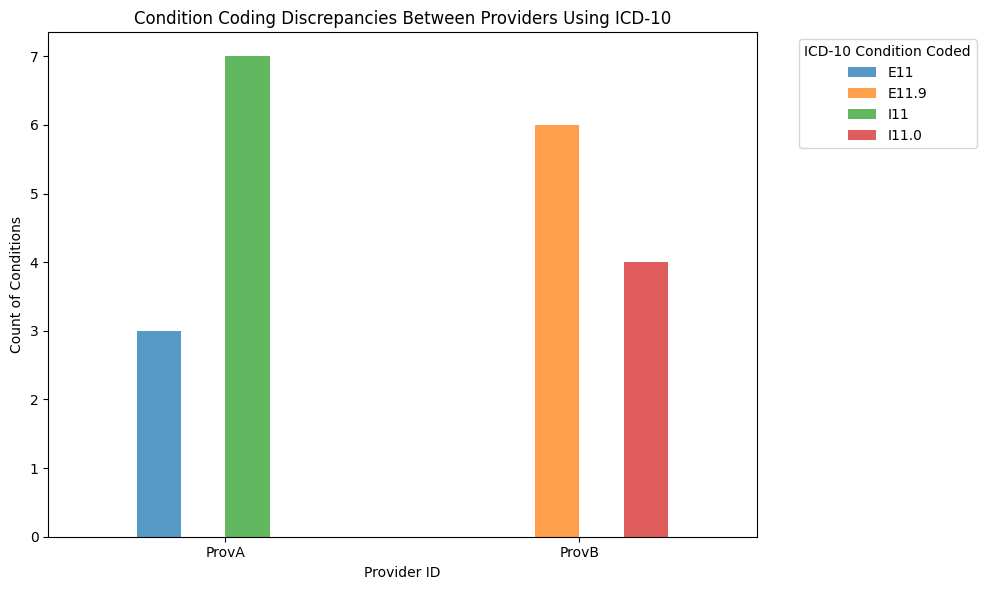

In [ ]:
adata = AnnData(
    obs=pd.DataFrame(
        {
            "patient_id": [
                "P1",
                "P2",
                "P3",
                "P4",
                "P5",
                "P6",
                "P7",
                "P8",
                "P9",
                "P10",
                "P1",
                "P2",
                "P3",
                "P4",
                "P5",
                "P6",
                "P7",
                "P8",
                "P9",
                "P10",
            ],
            "provider_id": ["ProvA"] * 10 + ["ProvB"] * 10,
            "condition_coded": ["E11"] * 3
            + ["I11"] * 7
            + ["E11.9"] * 6
            + ["I11.0"] * 4,
        }
    )
)
condition_counts = (
    adata.obs.groupby(["provider_id", "condition_coded"]).size().unstack(fill_value=0)
)

condition_counts.plot(kind="bar", figsize=(10, 6), alpha=0.75, rot=0)
plt.title("Condition Coding Discrepancies Between Providers Using ICD-10")
plt.ylabel("Count of Conditions")
plt.xlabel("Provider ID")
plt.xticks(range(len(condition_counts.index)), condition_counts.index)
plt.legend(title="ICD-10 Condition Coded", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Here, provider A used more general codes (E11 for type 2 diabetes mellitus and I11 for hypertensive heart diseases), whereas provider B used more specific codes (E11.9 for type 2 diabetes mellitus without complications and I11.0 for Hypertensive heart disease with heart failure.)

### Scenario: Overlapping symptoms

A more nuanced example of coding bias might involve different providers using entirely different codes for conditions that have overlapping symptoms or can be classified in multiple ways. For instance, some conditions have both acute and chronic forms, and providers might differ in their thresholds for coding one over the other.

Let's consider chest pain, which can be coded in multiple ways in ICD-10 based on its cause and nature:

- R07.9: Chest pain, unspecified
- I20.9: Angina pectoris, unspecified
- R07.2: Precordial pain

Let's assume that:

- Provider A tends to code most cases as unspecified chest pain (R07.9), but sometimes as angina (I20.9).
- Provider B tends to use the more specific precordial pain (R07.2) code frequently, but also uses the unspecified codes.

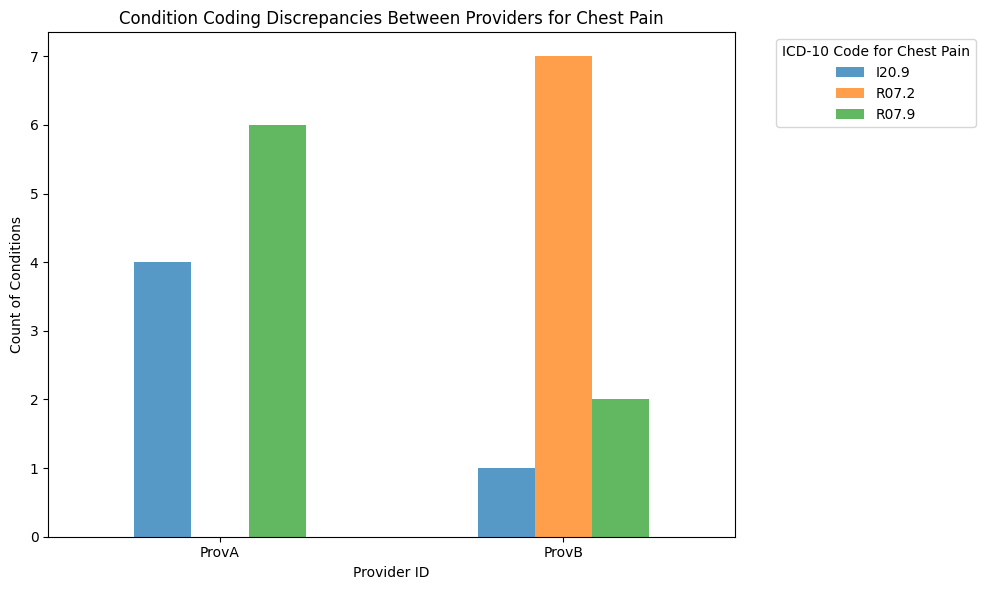

In [ ]:
adata = AnnData(
    obs=pd.DataFrame(
        {
            "patient_id": [
                "P1",
                "P2",
                "P3",
                "P4",
                "P5",
                "P6",
                "P7",
                "P8",
                "P9",
                "P10",
                "P11",
                "P12",
                "P13",
                "P14",
                "P15",
                "P16",
                "P17",
                "P18",
                "P19",
                "P20",
            ],
            "provider_id": ["ProvA"] * 10 + ["ProvB"] * 10,
            # Different coding choices for chest pain by providers
            "condition_coded": ["R07.9"] * 6
            + ["I20.9"] * 4
            + ["R07.2"] * 7
            + ["R07.9"] * 2
            + ["I20.9"] * 1,
        }
    )
)

condition_counts = (
    adata.obs.groupby(["provider_id", "condition_coded"]).size().unstack(fill_value=0)
)

condition_counts.plot(kind="bar", figsize=(10, 6), alpha=0.75, rot=0)
plt.title("Condition Coding Discrepancies Between Providers for Chest Pain")
plt.ylabel("Count of Conditions")
plt.xlabel("Provider ID")
plt.xticks(range(len(condition_counts.index)), condition_counts.index)
plt.legend(
    title="ICD-10 Code for Chest Pain", bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.tight_layout()
plt.show()

### Mitigation strategies

- Ask your data collection partners to enforce standardized protocols and training for coding practices to ensure consistency across different healthcare providers and settings.
- Provide ongoing training and updates for medical coders and healthcare providers about the latest coding standards (e.g., ICD-10, CPT codes) to maintain accuracy and reduce variability.
- Implement procedures for cross-checking codes entered into the EHR by different coders or systems, and validate coding accuracy with actual clinical documentation.
- Consider using disease ontologies such as [Mondo](https://mondo.monarchinitiative.org) to reduce the variability in how different providers and ontologies code the same condition.

We provide a tutorial on how to map against Disease ontologies [here](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/ontology_mapping.html).

## Attrition bias

Attrition bias emerges when there is a systematic difference between participants who continue to be followed up within the healthcare system and those who are lost to follow-up or withdraw from the system.
This can lead to skewed outcomes or distorted associations in longitudinal studies, as the data may no longer be representative of the original population.
For example, if patients with more severe conditions are more likely to remain engaged in the healthcare system for ongoing treatment, studies may overestimate the prevalence of these conditions and their associated healthcare outcomes.

### Scenario: Follow up severeity has censored patients
To illustrate the attrition bias, we consider a hypothetical scenario of 100 patients, of which roughly 70% have a "mild" condition and 30% have a "severe" condition.

We represent what a distribution could look like, if we assume that of the "mild" condition, only ~60% stay within the monitoring system, while all of the "severe" condition stay within the monitoring system due to continued visits to health facilities.

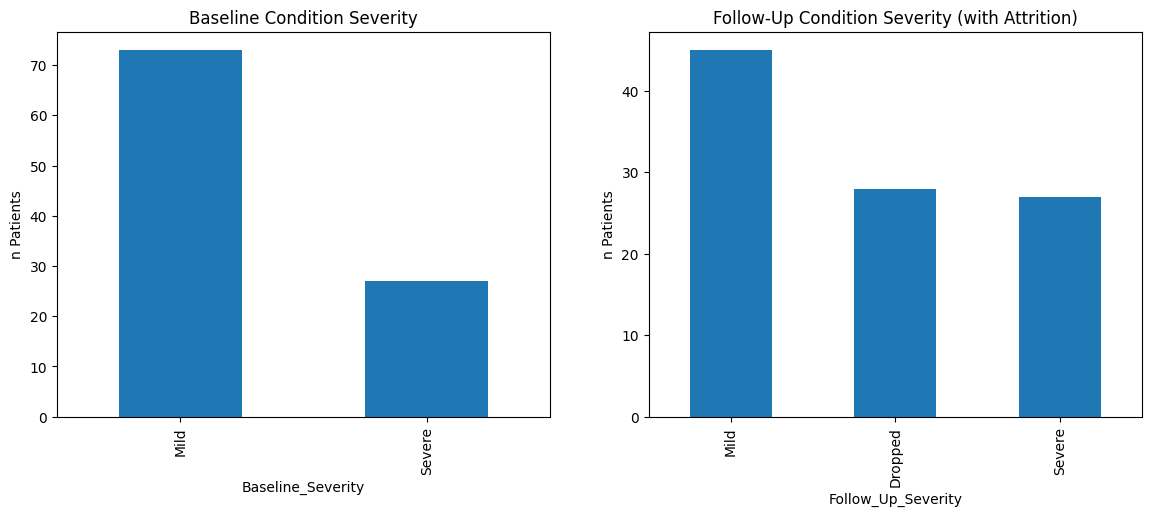

Chi-square p-value: 3.000103672728807e-08


In [27]:
from scipy.stats import chi2_contingency

NUM_PATIENTS = 100
NUM_MILD = 70
NUM_SEVERE = 30

P_MILD_DROPPING = 1-0.6

rng = np.random.default_rng(seed=42)
patient_ids = np.arange(NUM_PATIENTS)
condition_severity = rng.choice(["Mild", "Severe"], size=NUM_PATIENTS, p=[NUM_MILD/NUM_PATIENTS, NUM_SEVERE/NUM_PATIENTS])
follow_up_severity = [
    severity if (severity == "Severe" or rng.random() > P_MILD_DROPPING) else "Dropped"
    for severity in condition_severity
]

adata = AnnData(
    X=np.zeros((len(patient_ids), 1)),
    obs=pd.DataFrame(
        {
            "Baseline_Severity": condition_severity,
            "Follow_Up_Severity": follow_up_severity,
        },
        index=patient_ids,
    ),
)

baseline_counts = (
    adata.obs["Baseline_Severity"]
    .value_counts()
    .reindex(["Mild", "Severe", "Dropped"], fill_value=0)
)
followup_counts = (
    adata.obs["Follow_Up_Severity"]
    .value_counts()
    .reindex(["Mild", "Severe", "Dropped"], fill_value=0)
)
contingency_table = pd.concat([baseline_counts, followup_counts], axis=1)
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
adata.obs["Baseline_Severity"].value_counts().plot(kind="bar", ax=ax[0])
ax[0].set_title("Baseline Condition Severity")
adata.obs["Follow_Up_Severity"].value_counts().plot(kind="bar", ax=ax[1])
ax[1].set_title("Follow-Up Condition Severity (with Attrition)")
ax[0].set_ylabel("n Patients")
ax[1].set_ylabel("n Patients")
plt.show()

print(f"Chi-square p-value: {p_val}")

The attrition bias is evident when the proportion of patients with 'Severe' conditions increases from baseline to follow-up, not because the condition of patients worsens over time, but because those with 'Mild' conditions are more likely to drop out ('Dropped').
The chi-square test determined (p value < 0.05) that the distribution of categoricals differs between base line and follow up.

### Mitigation strategies

- Encourage data collectors to implement robust follow-up procedures to minimize loss to follow-up. Use multiple contact methods and reminders to keep participants engaged over the study period.
- Systematically collect and analyze reasons for dropout to understand if they are related to the study conditions or other factors, which could indicate bias.
- Compare baseline characteristics of participants who drop out versus those who remain to identify any significant differences that could influence the findings.

## Confounding bias

Confounding bias arises when an outside variable, not accounted for in the analysis, influences both the exposure of interest and the outcome, leading to a spurious association between them.
This can distort the true effect of the exposure on the outcome, either exaggerating or underestimating it.
For example, if a study investigating the effect of a medication on disease progression fails to account for the severity of illness at baseline, any observed effect might be due more to the initial health status of the patient than to the medication itself.

### Scenario: Severeity if illness as confounder

We simulates a scenario where patients receive medication that has a positive effect on an outcome.
However, the severity of illness at baseline (a confounder) also affects the outcome and is negatively correlated with it.
We consider 100 patients, and a baseline health status quantity that follows a normal distribution with mean 50 and standard deviation 10. We model a positive medication effect with a mean of 5, and a standard deviation of 2.


Correlation between Medication Effect and Outcome: 0.35044542476416013
Correlation between Baseline Health Status and Outcome: 0.590971020676291


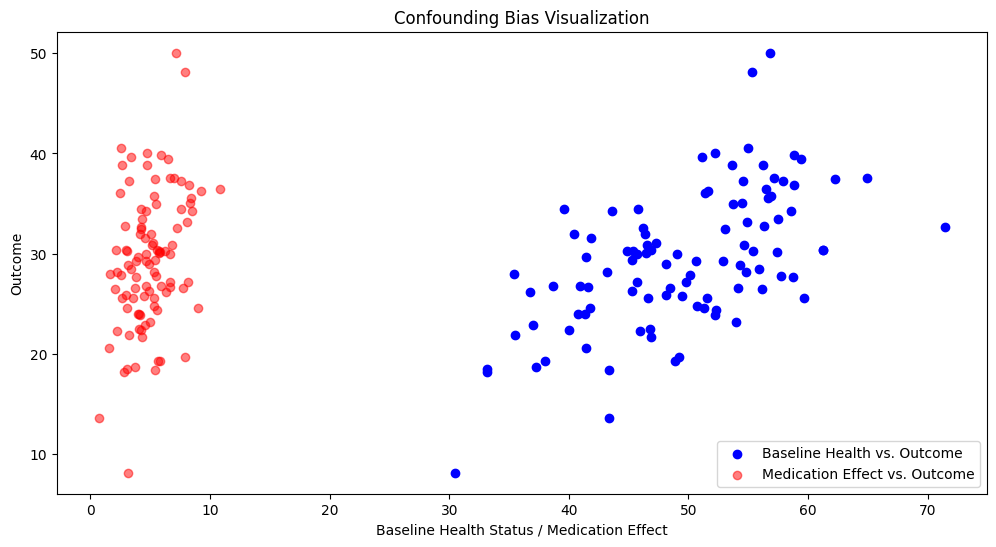

                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     37.62
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           8.06e-13
Time:                        14:00:27   Log-Likelihood:                -304.74
No. Observations:                 100   AIC:                             615.5
Df Residuals:                      97   BIC:                             623.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
from scipy.stats import pearsonr

rng = np.random.default_rng(42)
NUM_PATIENTS = 100
BASELINE_MEAN = 50
BASELINE_STD = 10
TREATMENT_EFFECT = 5
TREATMENT_EFFECT_STD = 2
baseline_health_status = rng.normal(BASELINE_MEAN, BASELINE_STD, NUM_PATIENTS)
positive_medication_effect = rng.normal(TREATMENT_EFFECT, TREATMENT_EFFECT_STD, NUM_PATIENTS)
negative_confounder_effect = baseline_health_status * -0.5
outcome = (
    baseline_health_status
    + positive_medication_effect
    + negative_confounder_effect
    + rng.normal(0, 5, NUM_PATIENTS)
)

adata = AnnData(
    X=outcome.reshape(-1, 1),
    obs=pd.DataFrame(
        {
            "Baseline Health Status": baseline_health_status,
            "Medication Effect": positive_medication_effect,
            "Outcome": outcome,
        },
        index=pd.Index(
            [f"Patient_{i}" for i in range(NUM_PATIENTS)], name="Patient ID"
        ),
    ),
)

corr_med_effect_outcome, _ = pearsonr(
    adata.obs["Medication Effect"], adata.obs["Outcome"]
)
corr_baseline_outcome, _ = pearsonr(
    adata.obs["Baseline Health Status"], adata.obs["Outcome"]
)

print(f"Correlation between Medication Effect and Outcome: {corr_med_effect_outcome}")
print(
    f"Correlation between Baseline Health Status and Outcome: {corr_baseline_outcome}"
)

plt.figure(figsize=(12, 6))
plt.scatter(
    adata.obs["Baseline Health Status"],
    adata.obs["Outcome"],
    c="blue",
    label="Baseline Health vs. Outcome",
)
plt.scatter(
    adata.obs["Medication Effect"],
    adata.obs["Outcome"],
    c="red",
    alpha=0.5,
    label="Medication Effect vs. Outcome",
)
plt.xlabel("Baseline Health Status / Medication Effect")
plt.ylabel("Outcome")
plt.legend()
plt.title("Confounding Bias Visualization")
plt.show()

# Mitigation strategy: Include baseline health status as a covariate in a regression model
from statsmodels.formula.api import ols

model = ols(
    "Outcome ~ Q('Medication Effect') + Q('Baseline Health Status')", data=adata.obs
).fit()
print(model.summary())

The stronger correlation of the baseline health status and the outcome compared to the medication and the outcome suggests that the baseline health status is a confounder.
It can be observed that patients with different baseline health statuses have different outcomes even before considering the medication effect.

### Mitigation strategies

To mitigate confounding bias, including the baseline health status as a covariate in a regression model allows for the adjustment of the medication effect on the outcome for the variance explained by baseline health status.
The ols regression model fits an ordinary least squares regression using the outcome as the dependent variable and both the medication effect and baseline health status as independent variables.
The regression has adjusted for the confounding variable (baseline health status), and the medication effect remains significant.
Finally, the results provide evidence against the null hypothesis (that the medication has no effect) and affirm that the medication does have a significant effect on the outcome when the baseline health status is taken into account.

More generally, we recommend to:

- Plan the study with consideration for potential confounders, ensuring that data on all relevant variables is collected.
- Stratify the data during analysis to control for confounding factors, analyzing the effects within each stratum of the confounder.
- Employ propensity score matching, stratification, or weighting to balance the distribution of confounding variables between treated and control groups.
- Conduct sensitivity analyses to determine how robust the results are to potential confounding.
- Consider reducing the feature representation to a smaller set of unrelated components through, for example, PCA.

## Normalization bias

Normalization biases arise when the methods used to standardize or normalize data across different scales or distributions inadvertently distort the underlying relationships or magnitudes in the data.
This can occur if the normalization technique does not account for intrinsic variability within subgroups or assumes a uniform distribution where it does not exist, leading to misleading interpretations of the data's true structure.
For example, applying the same normalization method to clinical measurements that vary widely between demographic groups (e.g., pediatric vs. adult populations) can mask important physiological differences and affect the accuracy of subsequent analyses.

### Scenario: Normalizing separately and jointly

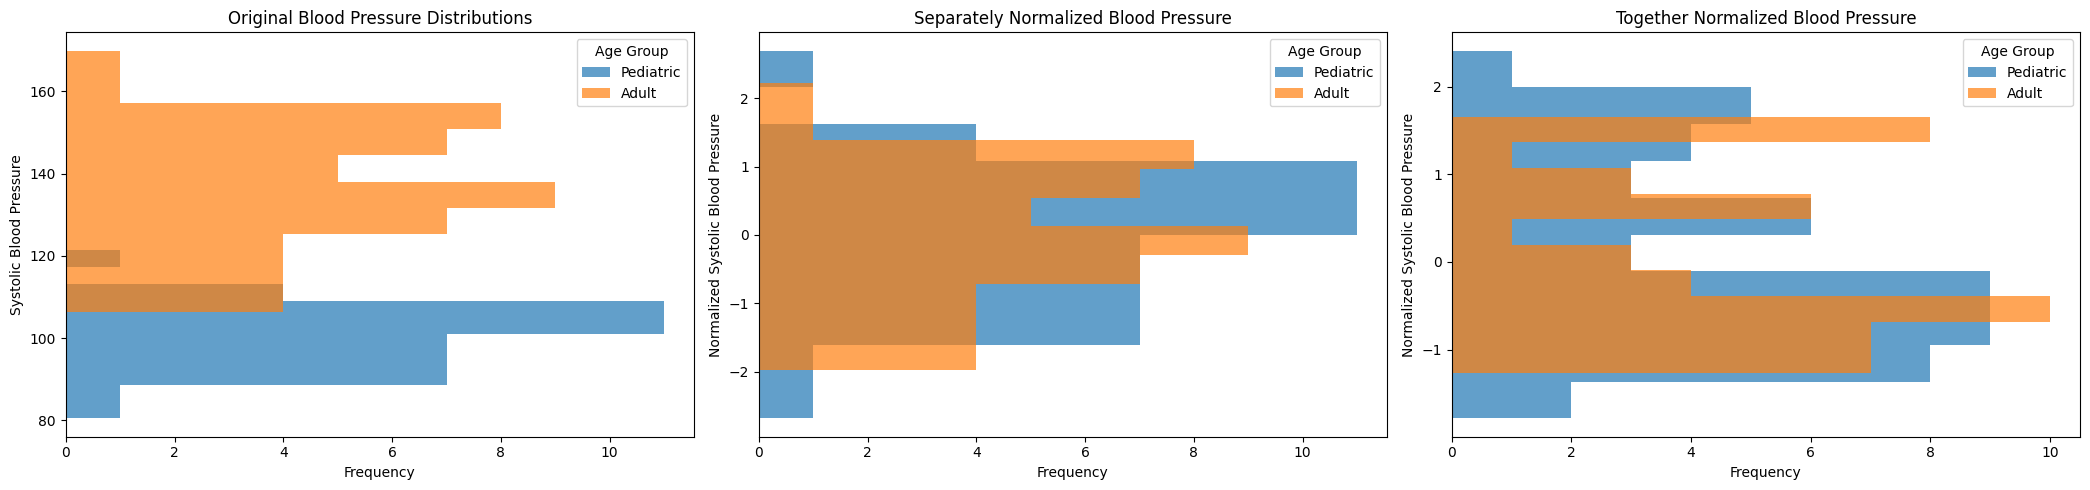

In [ ]:
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(seed=42)
pediatric_systolic_bp = rng.normal(loc=100, scale=10, size=50)
adult_systolic_bp = rng.normal(loc=140, scale=20, size=50)

adata = AnnData(np.column_stack([pediatric_systolic_bp, adult_systolic_bp]))
adata.var_names = ["Pediatric_Systolic_BP", "Adult_Systolic_BP"]

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].hist(
    adata[:, "Pediatric_Systolic_BP"].X,
    bins=10,
    alpha=0.7,
    label="Pediatric",
    orientation="horizontal",
)
axs[0].hist(
    adata[:, "Adult_Systolic_BP"].X,
    bins=10,
    alpha=0.7,
    label="Adult",
    orientation="horizontal",
)
axs[0].set_ylabel("Systolic Blood Pressure")
axs[0].set_xlabel("Frequency")
axs[0].legend(title="Age Group")
axs[0].set_title("Original Blood Pressure Distributions")

scaler = StandardScaler()
pediatric_systolic_bp_norm = scaler.fit_transform(
    adata[:, "Pediatric_Systolic_BP"].X
).flatten()
adult_systolic_bp_norm = scaler.fit_transform(adata[:, "Adult_Systolic_BP"].X).flatten()
adata.layers["normalized"] = np.column_stack(
    [pediatric_systolic_bp_norm, adult_systolic_bp_norm]
)

axs[1].hist(
    adata[:, "Pediatric_Systolic_BP"].layers["normalized"],
    bins=10,
    alpha=0.7,
    label="Pediatric",
    orientation="horizontal",
)
axs[1].hist(
    adata[:, "Adult_Systolic_BP"].layers["normalized"],
    bins=10,
    alpha=0.7,
    label="Adult",
    orientation="horizontal",
)
axs[1].set_ylabel("Normalized Systolic Blood Pressure")
axs[1].set_xlabel("Frequency")
axs[1].legend(title="Age Group")
axs[1].set_title("Separately Normalized Blood Pressure")

combined_bp_norm = (
    StandardScaler().fit_transform(adata.X.flatten().reshape(-1, 1)).flatten()
)
adata.layers["normalized_together"] = np.column_stack(
    [combined_bp_norm[:50], combined_bp_norm[50:]]
)
axs[2].hist(
    adata[:, "Pediatric_Systolic_BP"].layers["normalized_together"],
    bins=10,
    alpha=0.7,
    label="Pediatric",
    orientation="horizontal",
)
axs[2].hist(
    adata[:, "Adult_Systolic_BP"].layers["normalized_together"],
    bins=10,
    alpha=0.7,
    label="Adult",
    orientation="horizontal",
)
axs[2].set_ylabel("Normalized Systolic Blood Pressure")
axs[2].set_xlabel("Frequency")
axs[2].legend(title="Age Group")
axs[2].set_title("Together Normalized Blood Pressure")

plt.tight_layout()
plt.show()

Normalizing the distributions individually can mask the differences between the distributions.
This bias can be mitigated by normalizing both distributions jointly.
However, this can also come at a cost when the modalities are very different.

### Scenario: Normalizing different modalities

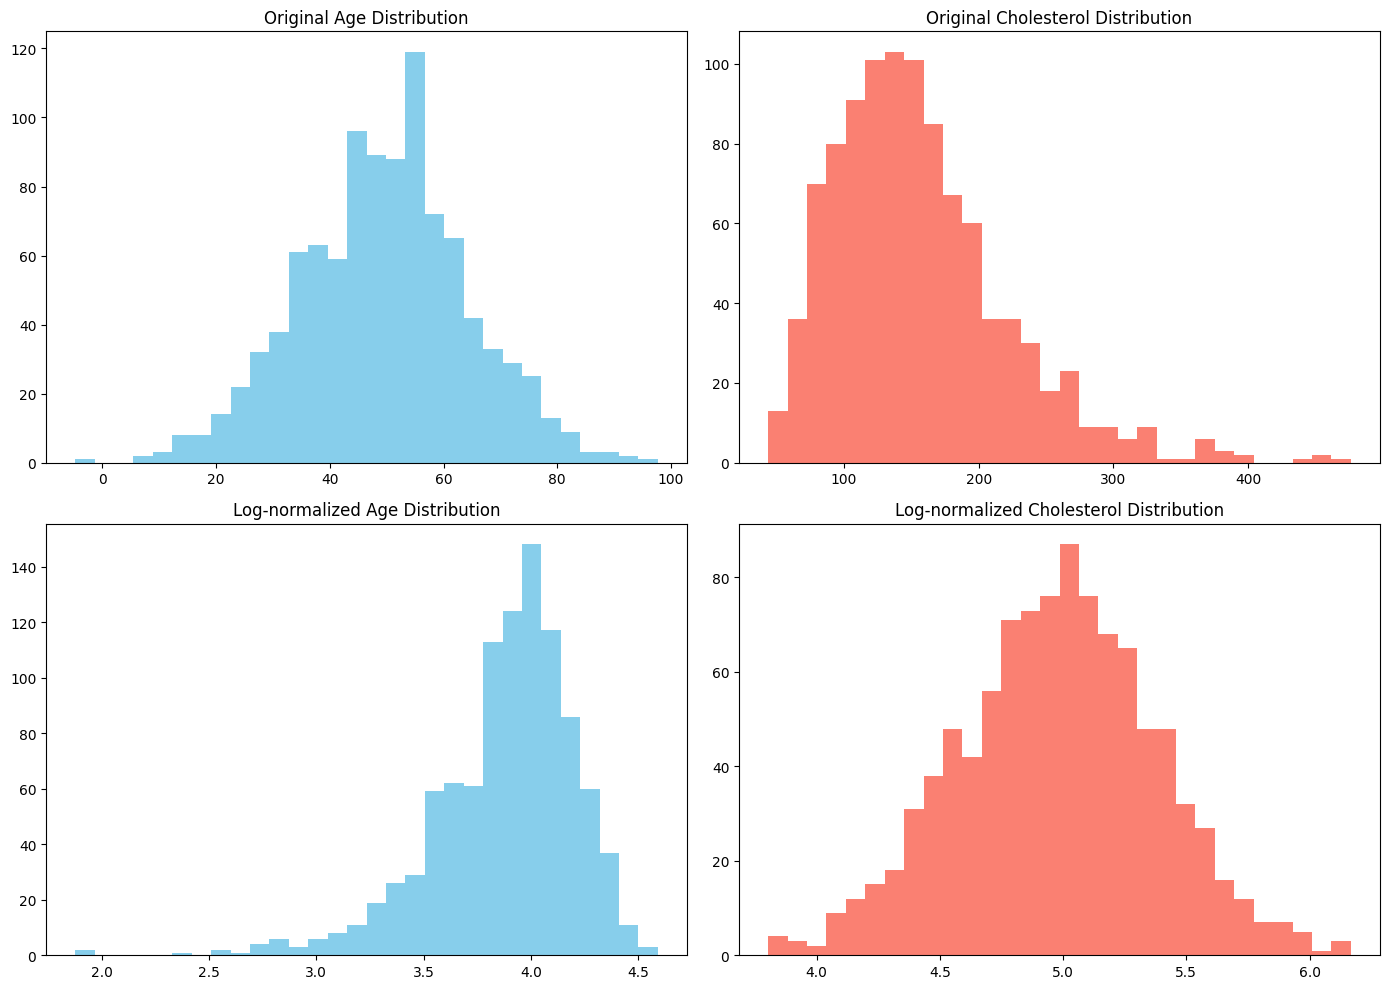

In [28]:
rng = np.random.default_rng(seed=42)
n_samples = 1000

ages = rng.normal(50, 15, n_samples)
cholesterol = rng.lognormal(5, 0.4, n_samples)

adata = AnnData(pd.DataFrame({"Age": ages, "Cholesterol": cholesterol}))
adata.layers["log_normalized"] = np.log1p(adata.X)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].hist(adata.X[:, 0], bins=30, color="skyblue")
axs[0, 0].set_title("Original Age Distribution")
axs[1, 0].hist(adata.layers["log_normalized"][:, 0], bins=30, color="skyblue")
axs[1, 0].set_title("Log-normalized Age Distribution")
axs[0, 1].hist(adata.X[:, 1], bins=30, color="salmon")
axs[0, 1].set_title("Original Cholesterol Distribution")
axs[1, 1].hist(adata.layers["log_normalized"][:, 1], bins=30, color="salmon")
axs[1, 1].set_title("Log-normalized Cholesterol Distribution")

plt.tight_layout()
plt.show()

We can observe that the originally normal (age) and log normal (cholesterol) distributed features have now switched their distributions.
This can be an unintended side effect of normalization.

### Mitigation strategies

- Ask data collectors to adhere to standardized protocols across all sites and providers to ensure consistency in how data is recorded.
- Choose robust normalization methods that are suitable for the type of data and the analytical goals. Methods like z-score normalization or min-max scaling can be employed to standardize data ranges without distorting relationships in the data.

## Conclusion

Biases in (EHR) data, as well as models and analyses building on it, can occur in many forms, and sometimes be hard to find.
Discussions with experts in the domain where the data was acquired, exploratory data analysis, and reporting of processing steps and are required towards mitigating biases.